In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Disinstalla completamente transformers e dipendenze collegate
!pip uninstall -y transformers accelerate sentence-transformers

# 2. Installa una versione stabile e coerente
!pip install --no-cache-dir transformers==4.55.2

# 3. Installa le altre librerie necessarie
!pip install --no-cache-dir datasets evaluate accelerate jiwer
!pip install torchaudio --quiet


Found existing installation: transformers 4.56.1
Uninstalling transformers-4.56.1:
  Successfully uninstalled transformers-4.56.1
Found existing installation: accelerate 1.10.1
Uninstalling accelerate-1.10.1:
  Successfully uninstalled accelerate-1.10.1
Found existing installation: sentence-transformers 5.1.0
Uninstalling sentence-transformers-5.1.0:
  Successfully uninstalled sentence-transformers-5.1.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 198.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 324.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.0
    Uninstalling tokenizers-0.22.0:
      Successfully uninstalled tokenizers-0.22.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.1

In [ ]:
import transformers
import accelerate

print("Transformers:", transformers.__version__)
print("Accelerate:", accelerate.__version__)


In [ ]:
!pip install torchaudio transformers datasets soundfile
!apt-get install -y ffmpeg


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import pandas as pd
import os
import torchaudio
from datasets import Dataset, DatasetDict
from transformers import AutoProcessor

# === CONFIG ===
CSV_PATH = "/content/drive/MyDrive/TesiMaggistrale/audiErrati/merged_dataset.csv"
SAMPLING_RATE = 16000
PRETRAINED_MODEL_NAME = "airesearch/wav2vec2-large-xlsr-53-th"
OUTPUT_DIR = "/content/drive/MyDrive/TesiMaggistrale/audiErrati/modello_finetunato_th_errori"

# === STEP 1: Carica il CSV e filtra file audio esistenti ===
df = pd.read_csv(CSV_PATH)
df = df[["audio_path", "trascrizione_errata"]].dropna()

# Verifica che i file audio esistano
df = df[df["audio_path"].apply(os.path.exists)]

# Crea Dataset HuggingFace ===
dataset = Dataset.from_pandas(df)
dataset = dataset.rename_column("audio_path", "path")
dataset = dataset.rename_column("trascrizione_errata", "text")

# Carica il processor ===
processor = AutoProcessor.from_pretrained(PRETRAINED_MODEL_NAME)

# Prepara batch con torchaudio ===
def prepare_batch(batch):
    waveform, sr = torchaudio.load(batch["path"])

    # Resample se necessario
    if sr != SAMPLING_RATE:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=SAMPLING_RATE)
        waveform = resampler(waveform)

    # Estrai i valori da passare al modello
    input_values = processor(
        waveform.squeeze().numpy(), sampling_rate=SAMPLING_RATE
    ).input_values[0]

    # Tokenizza il testo target
    with processor.as_target_processor():
        labels = processor(batch["text"]).input_ids

    return {
        "input_values": input_values,
        "labels": labels
    }

# Preprocessing
dataset = dataset.map(prepare_batch, remove_columns=["path", "text"])

#  Split train/validation/test
# Prima separo il 20% (che diventerà test+validation)
train_valid_split = dataset.train_test_split(test_size=0.2, seed=42)

# Dal 20% ricavo metà come validation e metà come test (10% ciascuno)
valid_test_split = train_valid_split["test"].train_test_split(test_size=0.5, seed=42)

dataset_dict = DatasetDict({
    "train": train_valid_split["train"],       # 80%
    "validation": valid_test_split["train"],   # 10%
    "test": valid_test_split["test"]           # 10%
})

# Salvo il dataset preprocessato
dataset_dict.save_to_disk(OUTPUT_DIR)
print("Dataset preprocessato e salvato con successo in:", OUTPUT_DIR)


KeyboardInterrupt: 

In [ ]:
from datasets import load_from_disk

DATASET_PATH = "/content/drive/MyDrive/TesiMaggistrale/audiErrati/modello_finetunato_th_errori"
dataset = load_from_disk(DATASET_PATH)
print(dataset)
print(dataset["train"].features)
print("Train rows:", len(dataset["train"]))
print("validation rows: ", len(dataset["validation"]))
print("Test rows: ", len(dataset["test"]))

In [ ]:
import os
import torch
import numpy as np
import evaluate
from transformers import (
    AutoProcessor,
    AutoModelForCTC,
    TrainingArguments,
    Trainer,
    IntervalStrategy,
    EarlyStoppingCallback,
    set_seed,
)
from datasets import load_from_disk

# ---------------- CONFIG ----------------
MODEL_NAME = "airesearch/wav2vec2-large-xlsr-53-th"
DATASET_PATH = "/content/drive/MyDrive/TesiMaggistrale/audiErrati/modello_finetunato_th_errori"
OUTPUT_DIR = "/content/drive/MyDrive/TesiMaggistrale/audiErrati/wav2vec2_finetuned_th_erroriTotal"
SEED = 42

# evita warning HF_TOKEN (opzionale)
if "HF_TOKEN" not in os.environ:
    os.environ["HF_TOKEN"] = ""

# seed per riproducibilità
set_seed(SEED)

# ---------------- CARICA ----------------
dataset = load_from_disk(DATASET_PATH)
processor = AutoProcessor.from_pretrained(MODEL_NAME)

# ---------------- PREPROCESS: creazione input_values se necessario ----------------
# Se il dataset non ha 'input_values' ma ha 'audio', convertiamo waveform -> input_values
if "input_values" not in dataset["train"].column_names:
    if "audio" in dataset["train"].column_names:
        print("Campo 'input_values' non trovato: genero 'input_values' da 'audio' (mapping)...")

        def prepare_input(batch):
            # batch contiene singolo esempio quando batched=False
            audio = batch["audio"]
            # audio può essere un dict: {"array": ..., "sampling_rate": ...}
            if isinstance(audio, dict):
                array = audio["array"]
                sr = audio.get("sampling_rate", 16000)
            else:
                # fallback: se audio è già waveform
                array = audio
                sr = 16000
            # processor restituisce dict con 'input_values' come lista (anche per singolo sample)
            proc = processor(array, sampling_rate=sr)
            # proc['input_values'] è una lista di float (o lista di liste quando batched True)
            # per singolo sample prendo il primo elemento se è lista
            vals = proc["input_values"]
            # se vals è lista di liste, prendo vals[0]
            if isinstance(vals, list) and len(vals) > 0 and isinstance(vals[0], list):
                vals = vals[0]
            batch["input_values"] = vals
            return batch

        # map singolo (batched=False) per gestire sampling_rate variabili
        dataset = dataset.map(prepare_input)
        print("input_values generati.")
    else:
        print("Attenzione: nessun campo 'input_values' o 'audio' trovato nel dataset. Assicurati che il dataset contenga waveform o input_values.")

# ---------------- PREPROCESS: tokenizza labels di testo se necessario ----------------
possible_fields = ["labels", "text", "transcription", "target"]
label_field = None
for f in possible_fields:
    if f in dataset["train"].column_names:
        # controllo tipo del primo elemento
        sample_val = dataset["train"][0][f]
        if isinstance(sample_val, str) or (isinstance(sample_val, (list, tuple)) and len(sample_val) > 0 and isinstance(sample_val[0], str)):
            label_field = f
            break

if label_field is None:
    print("Nessun campo di trascrizione testuale trovato; presumo labels già tokenizzati (IDs).")
else:
    print(f"Field di trascrizione testuale individuato: '{label_field}'. Tokenizzo le trascrizioni in token ids...")

    def tokenize_labels(batch):
        texts = batch[label_field]
        # assicurati che texts sia lista
        if isinstance(texts, str):
            texts = [texts]
        tokenized = processor.tokenizer(texts, add_special_tokens=False)
        batch["labels"] = tokenized["input_ids"]
        return batch

    # batched mapping per velocità
    dataset = dataset.map(tokenize_labels, batched=True, batch_size=64)
    print("Tokenizzazione delle labels completata. Esempio:")
    print(dataset["train"][0])

# ---------------- MODELLO ----------------
model = AutoModelForCTC.from_pretrained(
    MODEL_NAME,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

# Abilita gradient checkpointing (evita consumo VRAM)
if hasattr(model, "gradient_checkpointing_enable"):
    model.gradient_checkpointing_enable()

# Sposta modello su device (Trainer lo fa internamente, ma utile per debug)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# ---------------- DATA COLLATOR (robusto) ----------------
def data_collator(batch):
    import torch
    # Input padding
    input_features = [torch.tensor(x["input_values"], dtype=torch.float) for x in batch]
    input_lengths = [f.shape[0] for f in input_features]
    padded_inputs = torch.nn.utils.rnn.pad_sequence(input_features, batch_first=True, padding_value=0.0)
    attention_mask = torch.zeros(padded_inputs.shape[:2], dtype=torch.long)
    for i, l in enumerate(input_lengths):
        attention_mask[i, :l] = 1

    # Labels padding (pad -> -100 per CTC loss ignore index)
    # Se labels sono stringhe per qualche motivo, fallback: convertire con tokenizer (ma idealmente sono IDs)
    label_features = []
    for x in batch:
        lab = x.get("labels", None)
        if lab is None:
            # se non trovi labels, assegna sequenza vuota
            label_features.append(torch.tensor([], dtype=torch.long))
        else:
            # se lab è una stringa, tokenizza al volo (gestione difensiva)
            if isinstance(lab, str):
                lab_ids = processor.tokenizer(lab, add_special_tokens=False)["input_ids"]
            else:
                lab_ids = lab
            label_features.append(torch.tensor(lab_ids, dtype=torch.long))

    if len(label_features) == 0:
        padded_labels = torch.zeros((len(batch), 0), dtype=torch.long)
    else:
        padded_labels = torch.nn.utils.rnn.pad_sequence(label_features, batch_first=True,
                                                        padding_value=processor.tokenizer.pad_token_id)
        padded_labels[padded_labels == processor.tokenizer.pad_token_id] = -100

    return {"input_values": padded_inputs, "attention_mask": attention_mask, "labels": padded_labels}

# ---------------- METRICA (robusta) ----------------

cer_metric = evaluate.load("cer")

def decode_preds_and_labels(pred_logits, label_ids):
    if isinstance(pred_logits, tuple):
        pred_logits = pred_logits[0]
    pred_ids = np.argmax(pred_logits, axis=-1)
    pred_strs = processor.batch_decode(pred_ids, group_tokens=True)
    pred_strs = [s.strip() for s in pred_strs]

    # decode labels
    lab_ids = np.where(label_ids == -100, processor.tokenizer.pad_token_id, label_ids)
    label_strs = processor.batch_decode(lab_ids, group_tokens=False)
    label_strs = [s.strip() for s in label_strs]

    return pred_strs, label_strs

def compute_metrics(pred):
    logits = pred.predictions
    if isinstance(logits, tuple):
        logits = logits[0]
    label_ids = pred.label_ids
    pred_strs, label_strs = decode_preds_and_labels(logits, label_ids)
    cer = cer_metric.compute(predictions=pred_strs, references=label_strs)
    return {"cer": cer}

# ---------------- TRAINING ARGUMENTS ----------------
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy=IntervalStrategy.EPOCH,
    num_train_epochs=20,
    fp16=torch.cuda.is_available(),
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=3e-5,
    save_total_limit=3,
    load_best_model_at_end=True,
    greater_is_better=False,
    report_to="none",
    dataloader_num_workers=2,
    group_by_length=False,
)


# ---------------- TRAINER ----------------
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

# ---------------- SMOKE TEST (opzionale ma consigliato) ----------------
print("Eseguo un smoke-test su una mini-batch per verificare shapes e forward pass...")
try:
    from torch.utils.data import DataLoader
    dl = DataLoader(dataset["train"].select(range(min(8, len(dataset["train"])))),
                    batch_size=4, collate_fn=data_collator)
    batch = next(iter(dl))
    print({k: (type(v), tuple(v.shape)) for k, v in batch.items()})
    # Quick forward
    model.eval()
    with torch.no_grad():
        out = model(input_values=batch["input_values"].to(device), attention_mask=batch["attention_mask"].to(device))
    print("logits shape:", out.logits.shape)
    print("Smoke-test OK.")
except Exception as e:
    print("Warning: smoke-test fallito:", e)
    print("Controlla i campi 'input_values' e 'labels' del dataset prima di procedere con training completo.")

# ---------------- TRAINER ----------------
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

# ---------------- TRAINING ----------------
try:
    trainer.train()
finally:
    trainer.save_model(OUTPUT_DIR)
    try:
        processor.save_pretrained(OUTPUT_DIR)
    except Exception as e:
        print("Non ho potuto salvare il processor:", e)

print("✅ Training terminato. Modello e processor salvati in:", OUTPUT_DIR)

# ---------------- TEST FINALE ----------------
print("\n📊 Valutazione finale sul test set...")
metrics_test = trainer.evaluate(eval_dataset=dataset["test"])
print(metrics_test)


KeyboardInterrupt: 

In [ ]:
!pip install pythainlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 78.4 MB/s eta 0:00:00


In [ ]:
# =========================
# INSTALLAZIONE DELLE LIBRERIE
# =========================

# Aggiorna pip
!pip install --upgrade pip

# Librerie principali
!pip install torch torchvision torchaudio --upgrade
!pip install transformers datasets
!pip install pandas matplotlib tqdm evaluate

# =========================
# IMPORT DELLE LIBRERIE
# =========================

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hugging Face Transformers e Datasets
from transformers import (
    AutoProcessor,
    AutoModelForCTC,
    TrainingArguments,
    Trainer,
    IntervalStrategy,
    EarlyStoppingCallback,
    set_seed
)
from datasets import load_from_disk
import evaluate

# Imposta device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device disponibile:", device)

# Seed per riproducibilità
SEED = 42
set_seed(SEED)

print("✅ Librerie installate e importate correttamente")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Device disponibile: cpu
✅ Librerie installate e importate correttamente


Codice per il plot della **loss** durante l'addestramento

Checkpoint migliore: /content/drive/MyDrive/TesiMaggistrale/audiErrati/wav2vec2_finetuned_th_erroriTotal/checkpoint-11067 con Validation Loss minima = 0.1572


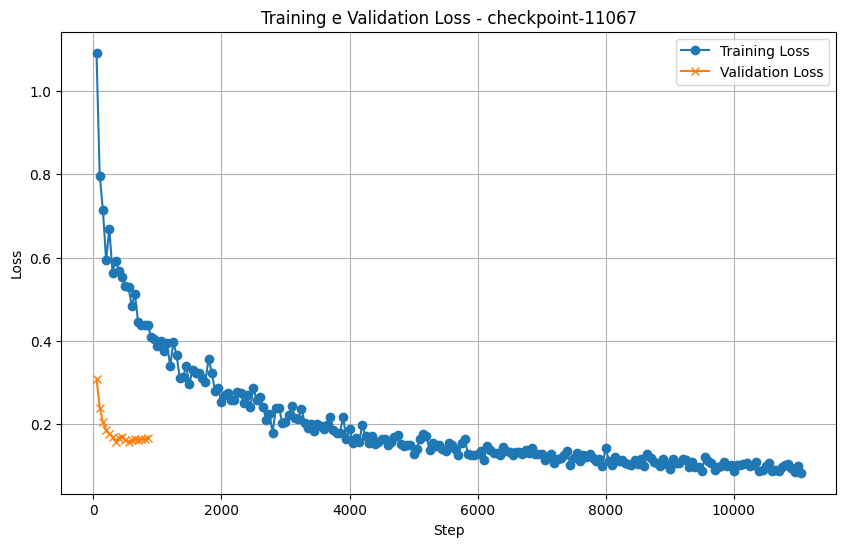

Tabella salvata in: /content/drive/MyDrive/TesiMaggistrale/audiErrati/wav2vec2_finetuned_th_erroriTotal/checkpoint-11067/loss_per_step.csv


In [ ]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

# -------------------- CONFIG --------------------
OUTPUT_DIRS = [
    "/content/drive/MyDrive/TesiMaggistrale/audiErrati/wav2vec2_finetuned_th_erroriTotal/checkpoint-11067",
    "/content/drive/MyDrive/TesiMaggistrale/audiErrati/wav2vec2_finetuned_th_erroriTotal/checkpoint-12369",
    "/content/drive/MyDrive/TesiMaggistrale/audiErrati/wav2vec2_finetuned_th_erroriTotal/checkpoint-13020"
]

best_val_loss = float('inf')
best_checkpoint = None
best_trainer_state = None

# -------------------- TROVA IL CHECKPOINT MIGLIORE --------------------
for OUTPUT_DIR in OUTPUT_DIRS:
    log_file = os.path.join(OUTPUT_DIR, "trainer_state.json")
    if not os.path.exists(log_file):
        print(f"File {log_file} non trovato! Passo al prossimo checkpoint.")
        continue

    with open(log_file, "r") as f:
        trainer_state = json.load(f)

    # Trova la min Validation Loss in questo checkpoint
    val_losses = [entry['eval_loss'] for entry in trainer_state['log_history'] if 'eval_loss' in entry]
    if val_losses and min(val_losses) < best_val_loss:
        best_val_loss = min(val_losses)
        best_checkpoint = OUTPUT_DIR
        best_trainer_state = trainer_state

if best_checkpoint is None:
    raise FileNotFoundError("Nessun checkpoint valido trovato!")

print(f"Checkpoint migliore: {best_checkpoint} con Validation Loss minima = {best_val_loss:.4f}")

# -------------------- ESTRAZIONE LOSS --------------------
train_losses = []
eval_losses = []
steps = []

for entry in best_trainer_state['log_history']:
    if 'loss' in entry:
        train_losses.append(entry['loss'])
        steps.append(entry.get('step', len(steps)+1))
    if 'eval_loss' in entry:
        eval_losses.append(entry['eval_loss'])

eval_steps = steps[:len(eval_losses)]

# -------------------- CREAZIONE GRAFICO --------------------
plt.figure(figsize=(10,6))
plt.plot(steps, train_losses, label="Training Loss", marker='o')
plt.plot(eval_steps, eval_losses, label="Validation Loss", marker='x')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title(f"Training e Validation Loss - {best_checkpoint.split('/')[-1]}")
plt.grid(True)
plt.legend()
plt.show()

# -------------------- CREAZIONE TABELLA --------------------
df = pd.DataFrame({
    "Step": steps[:len(train_losses)],
    "Train Loss": train_losses,
    "Validation Loss": [eval_losses[i] if i < len(eval_losses) else None for i in range(len(train_losses))]
})

csv_file = os.path.join(best_checkpoint, "loss_per_step.csv")
df.to_csv(csv_file, index=False)
print(f"Tabella salvata in: {csv_file}")
